## Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.layers import Reshape

2023-03-07 22:01:51.776985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 22:01:52.625540: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maddy/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-07 22:01:52.625638: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maddy/anaconda3/lib/python3.9/site-packages/cv2/../../lib

In [2]:
#Read dataset
df=pd.read_csv('1_percentage_of_target_fuzzy_dataset.csv')

In [3]:
df.tail(120)

,CAN ID,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7],Label
37528,1087,1,69,96,255,107,0,0,0,gear
37529,1087,1,69,96,255,107,0,0,0,gear
37530,1087,1,69,96,255,107,0,0,0,gear
37531,1087,1,69,96,255,107,0,0,0,gear
37532,1087,1,69,96,255,107,0,0,0,gear
...,...,...,...,...,...,...,...,...,...,...
37643,1087,1,69,96,255,107,0,0,0,gear
37644,1087,1,69,96,255,107,0,0,0,gear
37645,1087,1,69,96,255,107,0,0,0,gear
37646,1087,1,69,96,255,107,0,0,0,gear


In [4]:
df = df.drop('CAN ID', axis=1)

In [5]:
df

,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7],Label
0,41,39,39,35,0,0,0,154,R
1,20,0,0,0,0,0,0,0,R
2,0,0,0,128,0,104,209,19,R
3,12,182,127,20,17,32,0,20,R
4,0,0,0,0,2,32,43,52,R
...,...,...,...,...,...,...,...,...,...
37643,1,69,96,255,107,0,0,0,gear
37644,1,69,96,255,107,0,0,0,gear
37645,1,69,96,255,107,0,0,0,gear
37646,1,69,96,255,107,0,0,0,gear


In [6]:
# The labels of the dataset. "R" indicates normal patterns, and there are four types of attack (DoS, fuzzy. gear spoofing, and RPM spoofing zttacks)
df.Label.value_counts()

R        32520
Fuzzy     4978
gear       150
Name: Label, dtype: int64

In [7]:
# Transform all features into the scale of [0,1]
numeric_features = df.dtypes[df.dtypes != 'object'].index
scaler = QuantileTransformer() 
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [8]:
df

,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7],Label
0,0.644645,0.619620,0.641642,0.565566,0.000000,0.000000,0.000000,0.844344,R
1,0.514014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,R
2,0.000000,0.000000,0.000000,0.735736,0.000000,0.626627,0.965966,0.498999,R
3,0.452953,0.923924,0.834334,0.474975,0.509009,0.449950,0.000000,0.535536,R
4,0.000000,0.000000,0.000000,0.000000,0.389890,0.449950,0.757758,0.627628,R
...,...,...,...,...,...,...,...,...,...
37643,0.292793,0.696697,0.726226,1.000000,0.718719,0.000000,0.000000,0.000000,gear
37644,0.292793,0.696697,0.726226,1.000000,0.718719,0.000000,0.000000,0.000000,gear
37645,0.292793,0.696697,0.726226,1.000000,0.718719,0.000000,0.000000,0.000000,gear
37646,0.292793,0.696697,0.726226,1.000000,0.718719,0.000000,0.000000,0.000000,gear


In [9]:
# Multiply the feature values by 255 to transform them into the scale of [0,255]
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x*255))

### Generate images for each class

In [10]:
df0 = df[df['Label'] == 'R'].drop(['Label'], axis=1)
df1 = df[df['Label'] == 'Fuzzy'].drop(['Label'], axis=1)
df2 = df[df['Label'] == 'gear'].drop(['Label'], axis=1)

In [11]:
df2

,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7]
37498,74.662162,177.657658,185.187688,255.0,183.273273,0.0,0.0,0.0
37499,74.662162,177.657658,185.187688,255.0,183.273273,0.0,0.0,0.0
37500,74.662162,177.657658,185.187688,255.0,183.273273,0.0,0.0,0.0
37501,74.662162,177.657658,185.187688,255.0,183.273273,0.0,0.0,0.0
37502,74.662162,177.657658,185.187688,255.0,183.273273,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
37643,74.662162,177.657658,185.187688,255.0,183.273273,0.0,0.0,0.0
37644,74.662162,177.657658,185.187688,255.0,183.273273,0.0,0.0,0.0
37645,74.662162,177.657658,185.187688,255.0,183.273273,0.0,0.0,0.0
37646,74.662162,177.657658,185.187688,255.0,183.273273,0.0,0.0,0.0


In [12]:
# Generate 9*9 color images for class 0 (Normal)
# Change the numbers 9 to the number of features n in your dataset if you use a different dataset, reshape(n,n,3)
count=0
ims = []

image_path = "target/train/0/"
os.makedirs(image_path)

for i in range(0, len(df0)):  
    count=count+1
    if count<=24: 
        im=df0.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(8,8,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [13]:
# Generate 9*9 color images for class 1 (Fuzzy spoofing)
count=0
ims = []

image_path = "target/train/1/"
os.makedirs(image_path)

for i in range(0, len(df1)):  
    count=count+1
    if count<=24: 
        im=df1.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(8,8,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [14]:
# Generate 9*9 color images for class 1 (Fuzzy spoofing)
count=0
ims = []

image_path = "cluttered/"
os.makedirs(image_path)

for i in range(0, len(df2)):  
    count=count+1
    if count<=24: 
        im=df2.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(8,8,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'cluttered.png')
        count=0
        ims = []

### Display samples for each category

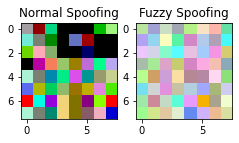

In [15]:
# Read the images for each category, the file name may vary (27.png, 83.png...)
img1 = Image.open('./target/train/0/24.png')
img2 = Image.open('./target/train/1/24.png')

plt.figure(figsize=(10, 10)) 
plt.subplot(1,5,1)
plt.imshow(img1)
plt.title("Normal Spoofing")
plt.subplot(1,5,2)
plt.imshow(img2)
plt.title("Fuzzy Spoofing")

plt.show()  # display it

## Split the training and test set 

In [16]:
# Create folders to store images
Train_Dir='./target/train/'
Val_Dir='./target/test/'
allimgs=[]
for subdir in os.listdir(Train_Dir):
    for filename in os.listdir(os.path.join(Train_Dir,subdir)):
        filepath=os.path.join(Train_Dir,subdir,filename)
        allimgs.append(filepath)
print(len(allimgs)) # Print the total number of images

1499


In [17]:
#split a test set from the dataset, train/test size = 80%/20%
Numbers=len(allimgs)//5 	#size of test set (20%)

def mymovefile(srcfile,dstfile):
    if not os.path.isfile(srcfile):
#         print ("%s not exist!"%(srcfile))
        pass
    else:
        fpath,fname=os.path.split(dstfile)    
        if not os.path.exists(fpath):
            os.makedirs(fpath)               
        shutil.move(srcfile,dstfile)          
        #print ("move %s -> %s"%(srcfile,dstfile))

In [18]:
# The size of test set
Numbers

299

In [19]:
# Create the test set
val_imgs=random.sample(allimgs,Numbers)
for img in val_imgs:
    dest_path=img.replace(Train_Dir,Val_Dir)
    mymovefile(img,dest_path)
print('Finish creating test set')

Finish creating test set


In [20]:
#resize the images 224*224 for better CNN training
def get_224(folder,dstdir):
    imgfilepaths=[]
    for root,dirs,imgs in os.walk(folder):
        for thisimg in imgs:
            thisimg_path=os.path.join(root,thisimg)
            imgfilepaths.append(thisimg_path)
    for thisimg_path in imgfilepaths:
        dir_name,filename=os.path.split(thisimg_path)
        dir_name=dir_name.replace(folder,dstdir)
        new_file_path=os.path.join(dir_name,filename)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        img=cv2.imread(thisimg_path)
        img=cv2.resize(img,(224,224))
        cv2.imwrite(new_file_path,img)
    print('Finish resizing'.format(folder=folder))

In [21]:
DATA_DIR_224='./target/train_224/'
get_224(folder='./target/train/',dstdir=DATA_DIR_224)

Finish resizing


In [22]:
DATA_DIR2_224='./target/test_224/'
get_224(folder='./target/test/',dstdir=DATA_DIR2_224)

Finish resizing


In [23]:
DATA_DIR2_224='./cluttered/cluttered_224/'
get_224(folder='./cluttered/',dstdir=DATA_DIR2_224)

Finish resizing
